# Setup

In [14]:
LOG_PLOT = False
NDAYS=50

In [15]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import os
from helper import *
from datetime import datetime
from ecdc import ECDC

## ECDC Data

In [16]:
ecdc = ECDC()
df = ecdc.df
print(ecdc.df.dateRep.max())
df.columns


2020-10-19 00:00:00


Index(['dateRep', 'day', 'month', 'year', 'cases', 'deaths',
       'countriesAndTerritories', 'geoId', 'countryterritoryCode',
       'popData2019', 'continentExp',
       'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'],
      dtype='object')

## DF Subsets

In [17]:
EU = df[df.continentExp=='Europe'].groupby('dateRep', as_index=False).agg({'cases': sum})
AMERICA = df[(df.continentExp=='America')]


<IPython.core.display.Javascript object>


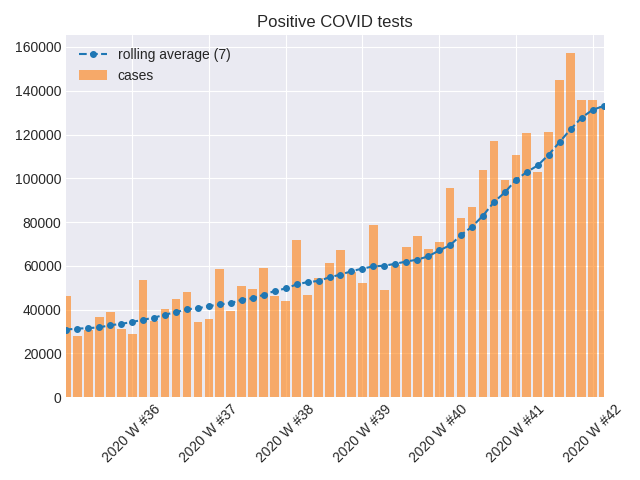

<AxesSubplot:title={'center':'Positive COVID tests'}>

In [18]:
ecdc.plot_selection(EU, ndays=NDAYS, roll_days=7)

# Overview

## Austria, USA, India, ...

<IPython.core.display.Javascript object>


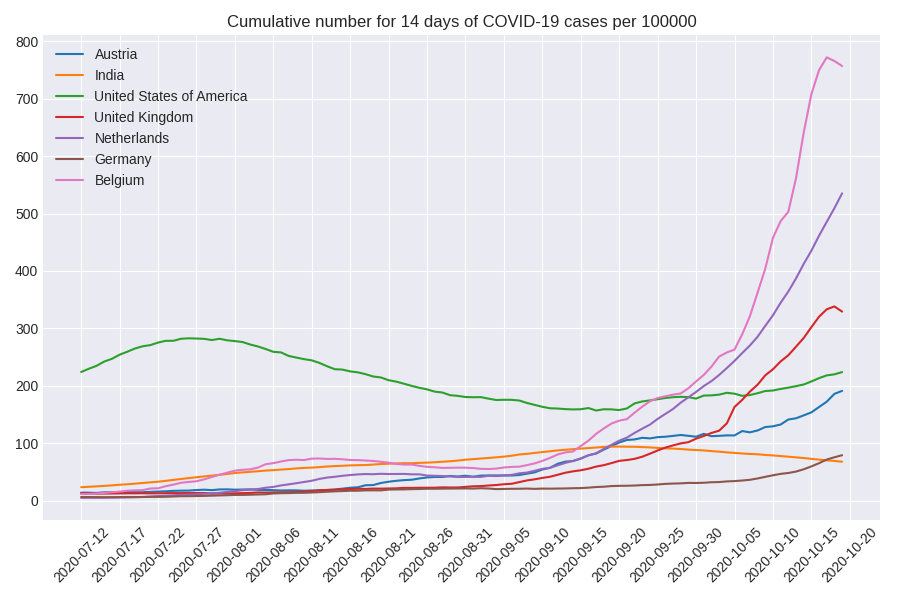

cases                                     \
                           rolling_avg                        last_5_days   
countriesAndTerritories                                                     
India                     61390.714286  67708, 63371, 62212, 61871, 55722   
United_States_of_America  56007.285714  59386, 63785, 70256, 56611, 47843   
United_Kingdom            16956.142857  19724, 18978, 15635, 16171, 16981   
Netherlands                7683.428571       7271, 7779, 7978, 8105, 8439   
Germany                    5852.571429       6638, 7334, 7830, 5587, 4325   
Belgium                    5496.857143             8216, 6266, 979, 34, 0   
Austria                    1367.714286       1606, 1396, 1691, 2040, 1062   

                                 deaths                              \
                            max     sum last_7_days_sum rolling_avg   
countriesAndTerritories                                               
India                     97894  114610            5460  780.000000   
United_States_of_America  78427  219674            4903  700.428571   
United_Kingdom            22961   43646             821  117.285714   
Netherlands                8439    6751             176   25.142857   
Germany                    7830    9789             168   24.000000   
Belgium                   12051   10413             163   23.285714   
Austria                    2040     910              46    6.571429   

                                                          \
                                       last_5_days   max   
countriesAndTerritories                                    
India                     680, 895, 837, 1033, 579  2003   
United_States_of_America   970, 828, 899, 690, 385  4928   
United_Kingdom              137, 138, 136, 150, 67  1224   
Netherlands                     32, 29, 16, 29, 23   234   
Germany                         33, 24, 33, 10, 12   315   
Belgium                           34, 29, 20, 4, 0   321   
Austria                              9, 6, 7, 6, 3    31   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
India                                                             67.801959           
United_States_of_America                                         223.891993           
United_Kingdom                                                   329.243074           
Netherlands                                                      535.147134           
Germany                                                           79.114217           
Belgium                                                          756.910272           
Austria                                                          191.211539           

                                      
                                 max  
countriesAndTerritories               
India                      94.173835  
United_States_of_America  282.723242  
United_Kingdom            338.215705  
Netherlands               535.147134  
Germany                    86.358323  
Belgium                   772.012163  
Austria                   191.211539

In [19]:
# countries = ['AT', 'IN', 'US', 'UK', 'DE', 'NL', 'FR',  'IT', 'ES','EL' ]
countries = ('AT', 'IN', 'US', 'UK', 'NL', 'DE', 'BE')
SELECTION =  df[df.geoId.isin(countries)]

ecdc.plot_comparison(countries, log=False, ndays=100)
ecdc.overview(SELECTION)

## Sweden and the world

<IPython.core.display.Javascript object>


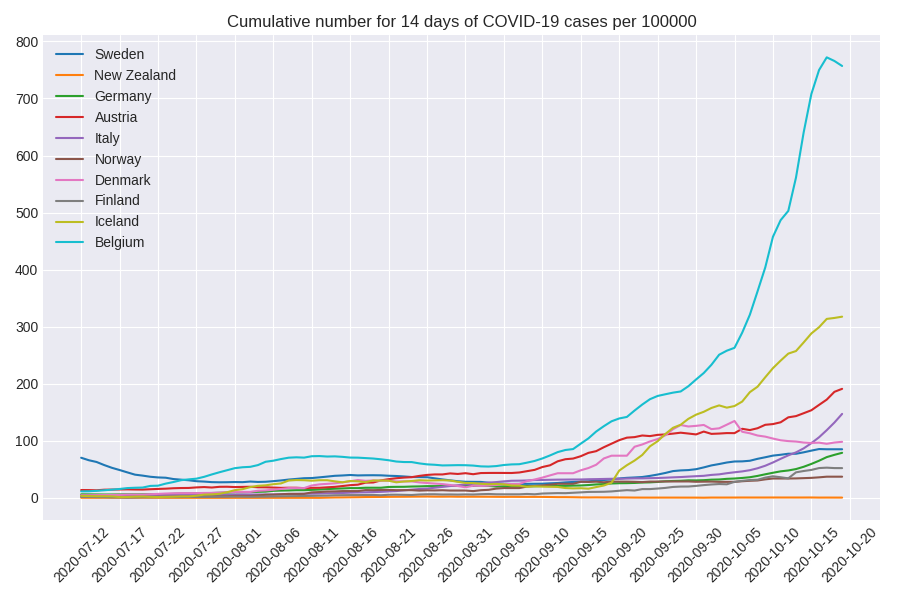

<AxesSubplot:title={'center':'Cumulative number for 14 days of COVID-19 cases per 100000'}>

In [22]:
countries = ('SE', 'NZ','DE','AT','IT','NO','DK','FI','IS','BE')
ecdc.plot_comparison(countries, log=False, ndays=100)


### World

In [11]:
ecdc.overview(df).head(5)

cases                                     \
                           rolling_avg                        last_5_days   
countriesAndTerritories                                                     
India                     61390.714286  67708, 63371, 62212, 61871, 55722   
United_States_of_America  56007.285714  59386, 63785, 70256, 56611, 47843   
France                    23151.428571  22591, 30621, 25086, 32427, 29837   
Brazil                    20051.714286  27235, 28523, 30914, 24062, 10982   
United_Kingdom            16956.142857  19724, 18978, 15635, 16171, 16981   

                                 deaths                              \
                            max     sum last_7_days_sum rolling_avg   
countriesAndTerritories                                               
India                     97894  114610            5460  780.000000   
United_States_of_America  78427  219674            4903  700.428571   
France                    32427   33477             747  106.714286   
Brazil                    69074  153905            3417  488.142857   
United_Kingdom            22961   43646             821  117.285714   

                                                          \
                                       last_5_days   max   
countriesAndTerritories                                    
India                     680, 895, 837, 1033, 579  2003   
United_States_of_America   970, 828, 899, 690, 385  4928   
France                        104, 88, 178, 89, 85  2004   
Brazil                     749, 713, 754, 461, 230  1595   
United_Kingdom              137, 138, 136, 150, 67  1224   

                         Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  \
                                                                             latest   
countriesAndTerritories                                                               
India                                                             67.801959           
United_States_of_America                                         223.891993           
France                                                           414.642659           
Brazil                                                           151.649244           
United_Kingdom                                                   329.243074           

                                      
                                 max  
countriesAndTerritories               
India                      94.173835  
United_States_of_America  282.723242  
France                    414.642659  
Brazil                    304.320523  
United_Kingdom            338.215705

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Plots

<IPython.core.display.Javascript object>


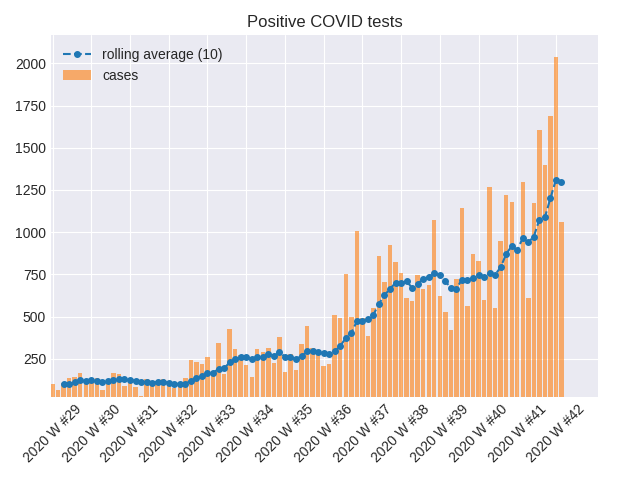

In [23]:
ecdc.plot_country('AT', log=LOG_PLOT, ndays=100, roll_days=10);

# India

<IPython.core.display.Javascript object>


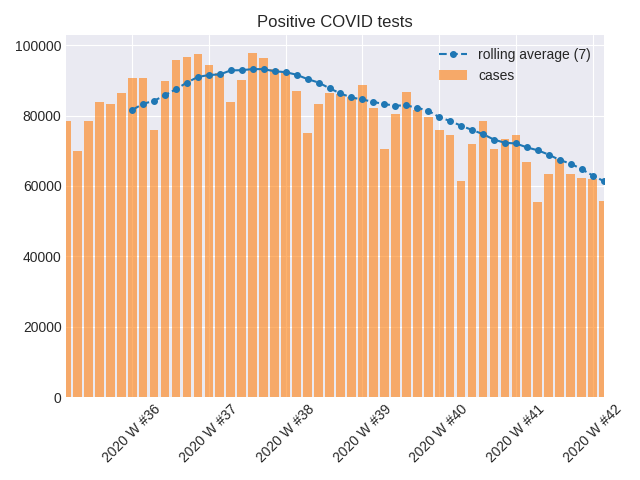

In [24]:
ecdc.plot_country('IN', log=LOG_PLOT,ndays=NDAYS, roll_days=7);

# USA

<IPython.core.display.Javascript object>


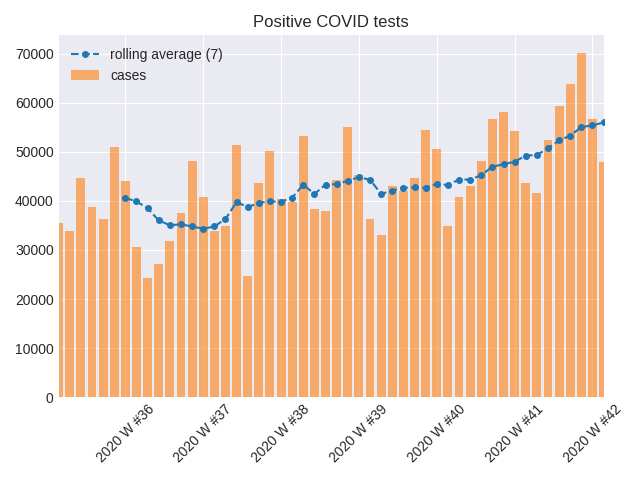

In [25]:
ecdc.plot_country('US', log=LOG_PLOT,ndays=NDAYS, roll_days=7);


# Germany

<IPython.core.display.Javascript object>


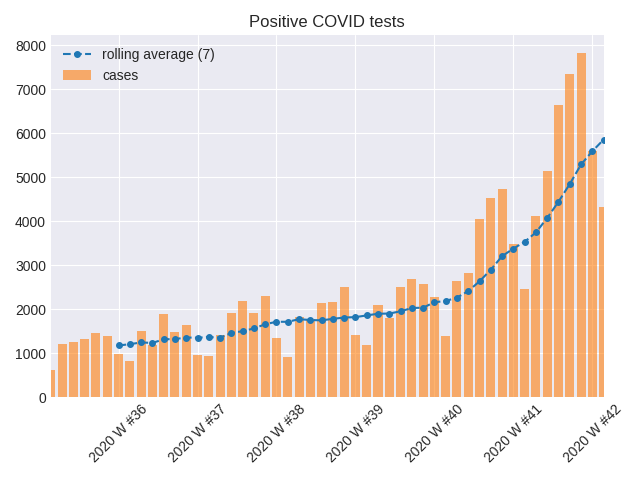

In [26]:
ecdc.plot_country('DE', log=LOG_PLOT,ndays=NDAYS, roll_days=7);

## UK

<IPython.core.display.Javascript object>


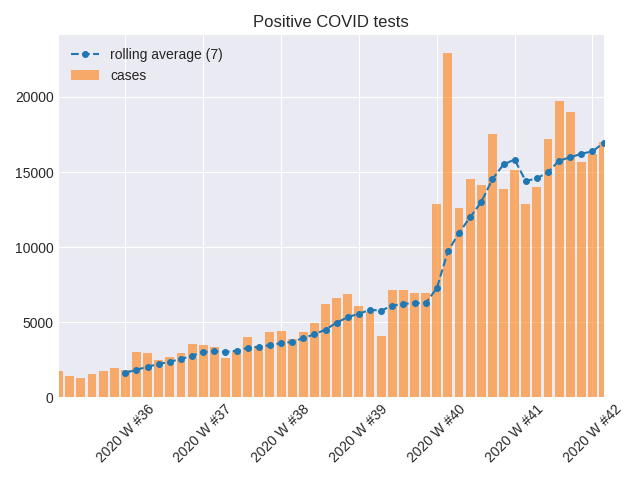

In [27]:
ecdc.plot_country('UK', log=LOG_PLOT,ndays=NDAYS,roll_days=7);

# Commit and Push

In [28]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[feature/angular 6a3cbde] Last run on 2020-10-20 08:38
 3 files changed, 246 insertions(+), 220 deletions(-)
Enumerating objects: 13, done.
Counting objects: 100% (12/12), done.
Delta compression using up to 16 threads
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 331.82 KiB | 5.92 MiB/s, done.
Total 7 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 5 local objects.
To github.com:gythaogg/covid19.git
   62eab47..6a3cbde  feature/angular -> feature/angular


In [41]:
! git push --set-upstream origin feature/angular


Branch 'feature/angular' set up to track remote branch 'feature/angular' from 'origin'.
Everything up-to-date
